In [12]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


# ANN vs CNN on MNIST Dataset

This notebook implements and compares two neural network architectures:
- **ANN (Artificial Neural Network)**: Fully connected layers
- **CNN (Convolutional Neural Network)**: Convolutional + Pooling + Fully connected layers

## 1. Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
from IPython.display import clear_output

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## 2. Load MNIST Dataset

In [2]:
# Data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

# Download and load training data
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# Download and load test data
test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Training samples: {len(train_dataset)}')
print(f'Test samples: {len(test_dataset)}')

100%|██████████| 9.91M/9.91M [00:01<00:00, 8.09MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 306kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.06MB/s]

Training samples: 60000
Test samples: 10000


## 3. Visualize Sample Images

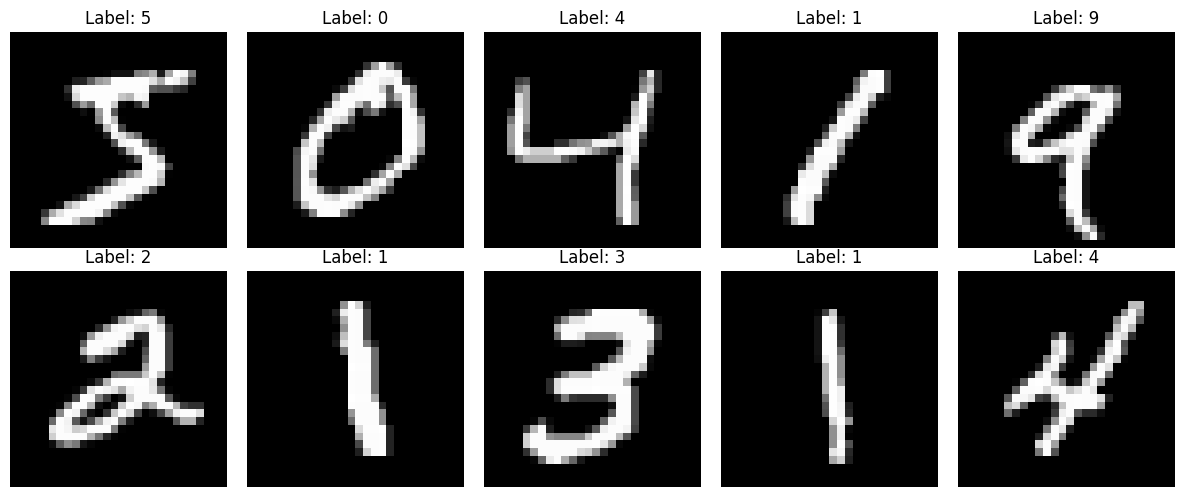

In [3]:
# Display sample images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    image, label = train_dataset[i]
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')
plt.tight_layout()
plt.show()

## 4. Define ANN Architecture (Fully Connected Network)

Architecture:
- Input: 28x28 = 784 features
- FC Layer 1: 784 → 128 neurons
- FC Layer 2: 128 → 64 neurons
- Output: 64 → 10 classes

In [4]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        # Flatten 28x28 images to 784 vector
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        # Flatten the input
        x = x.view(-1, 28 * 28)
        
        # First FC layer with ReLU
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        # Second FC layer with ReLU
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        # Output layer
        x = self.fc3(x)
        return x

# Create ANN model
ann_model = ANN().to(device)
print(ann_model)
print(f'\nTotal parameters: {sum(p.numel() for p in ann_model.parameters())}')

ANN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

Total parameters: 109386


## 5. Define CNN Architecture

Architecture:
- Input: 28x28x1 image
- Conv Layer 1: 32 filters (3x3)
- Conv Layer 2: 64 filters (3x3)
- Max Pooling: 2x2
- Fully Connected: 128 neurons
- Output: 10 classes

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        # After 2 pooling layers: 28 -> 14 -> 7
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        # First conv block
        x = F.relu(self.conv1(x))
        x = self.pool(x)  # 28x28 -> 14x14
        
        # Second conv block
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # 14x14 -> 7x7
        x = self.dropout(x)
        
        # Flatten
        x = x.view(-1, 64 * 7 * 7)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Create CNN model
cnn_model = CNN().to(device)
print(cnn_model)
print(f'\nTotal parameters: {sum(p.numel() for p in cnn_model.parameters())}')

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

Total parameters: 421642


## 6. Training Function

In [6]:
def train_model(model, train_loader, test_loader, epochs=10, lr=0.001):
    """
    Train a model and return training history
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': [],
        'time': []
    }
    
    for epoch in range(epochs):
        start_time = time.time()
        
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = output.max(1)
            train_total += target.size(0)
            train_correct += predicted.eq(target).sum().item()
        
        train_loss = train_loss / len(train_loader)
        train_acc = 100. * train_correct / train_total
        
        # Evaluation phase
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                
                test_loss += loss.item()
                _, predicted = output.max(1)
                test_total += target.size(0)
                test_correct += predicted.eq(target).sum().item()
        
        test_loss = test_loss / len(test_loader)
        test_acc = 100. * test_correct / test_total
        
        epoch_time = time.time() - start_time
        
        # Store history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        history['time'].append(epoch_time)
        
        print(f'Epoch [{epoch+1}/{epochs}] ({epoch_time:.2f}s) | '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | '
              f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
    
    return history

## 7. Train ANN Model

In [7]:
print("Training ANN Model...")
print("="*80)

ann_history = train_model(
    model=ann_model,
    train_loader=train_loader,
    test_loader=test_loader,
    epochs=10,
    lr=0.001
)

print("\nANN Training Complete!")
print(f"Final Test Accuracy: {ann_history['test_acc'][-1]:.2f}%")

Training ANN Model...
Epoch [1/10] (10.23s) | Train Loss: 0.4004, Train Acc: 87.96% | Test Loss: 0.1616, Test Acc: 95.13%
Epoch [2/10] (10.12s) | Train Loss: 0.1806, Train Acc: 94.63% | Test Loss: 0.1151, Test Acc: 96.33%
Epoch [3/10] (9.96s) | Train Loss: 0.1369, Train Acc: 95.87% | Test Loss: 0.1072, Test Acc: 96.73%
Epoch [4/10] (9.88s) | Train Loss: 0.1187, Train Acc: 96.47% | Test Loss: 0.0943, Test Acc: 97.10%
Epoch [5/10] (10.02s) | Train Loss: 0.1028, Train Acc: 96.82% | Test Loss: 0.0753, Test Acc: 97.65%
Epoch [6/10] (10.17s) | Train Loss: 0.0901, Train Acc: 97.25% | Test Loss: 0.0772, Test Acc: 97.80%
Epoch [7/10] (9.93s) | Train Loss: 0.0860, Train Acc: 97.35% | Test Loss: 0.0699, Test Acc: 97.78%
Epoch [8/10] (10.21s) | Train Loss: 0.0754, Train Acc: 97.68% | Test Loss: 0.0775, Test Acc: 97.67%
Epoch [9/10] (9.88s) | Train Loss: 0.0716, Train Acc: 97.75% | Test Loss: 0.0671, Test Acc: 97.88%
Epoch [10/10] (10.01s) | Train Loss: 0.0677, Train Acc: 97.83% | Test Loss: 0.0693

## 8. Train CNN Model

In [8]:
print("Training CNN Model...")
print("="*80)

cnn_history = train_model(
    model=cnn_model,
    train_loader=train_loader,
    test_loader=test_loader,
    epochs=10,
    lr=0.001
)

print("\nCNN Training Complete!")
print(f"Final Test Accuracy: {cnn_history['test_acc'][-1]:.2f}%")

Training CNN Model...
Epoch [1/10] (11.00s) | Train Loss: 0.1929, Train Acc: 94.00% | Test Loss: 0.0485, Test Acc: 98.31%
Epoch [2/10] (10.74s) | Train Loss: 0.0639, Train Acc: 98.05% | Test Loss: 0.0340, Test Acc: 98.89%
Epoch [3/10] (10.66s) | Train Loss: 0.0466, Train Acc: 98.49% | Test Loss: 0.0284, Test Acc: 99.01%
Epoch [4/10] (10.65s) | Train Loss: 0.0395, Train Acc: 98.73% | Test Loss: 0.0264, Test Acc: 99.15%
Epoch [5/10] (11.05s) | Train Loss: 0.0322, Train Acc: 98.94% | Test Loss: 0.0273, Test Acc: 99.06%
Epoch [6/10] (10.63s) | Train Loss: 0.0279, Train Acc: 99.11% | Test Loss: 0.0285, Test Acc: 99.04%
Epoch [7/10] (10.88s) | Train Loss: 0.0251, Train Acc: 99.17% | Test Loss: 0.0238, Test Acc: 99.22%
Epoch [8/10] (10.78s) | Train Loss: 0.0230, Train Acc: 99.25% | Test Loss: 0.0243, Test Acc: 99.15%
Epoch [9/10] (10.72s) | Train Loss: 0.0210, Train Acc: 99.30% | Test Loss: 0.0212, Test Acc: 99.28%
Epoch [10/10] (10.87s) | Train Loss: 0.0173, Train Acc: 99.45% | Test Loss: 0.

## 9. Compare Results

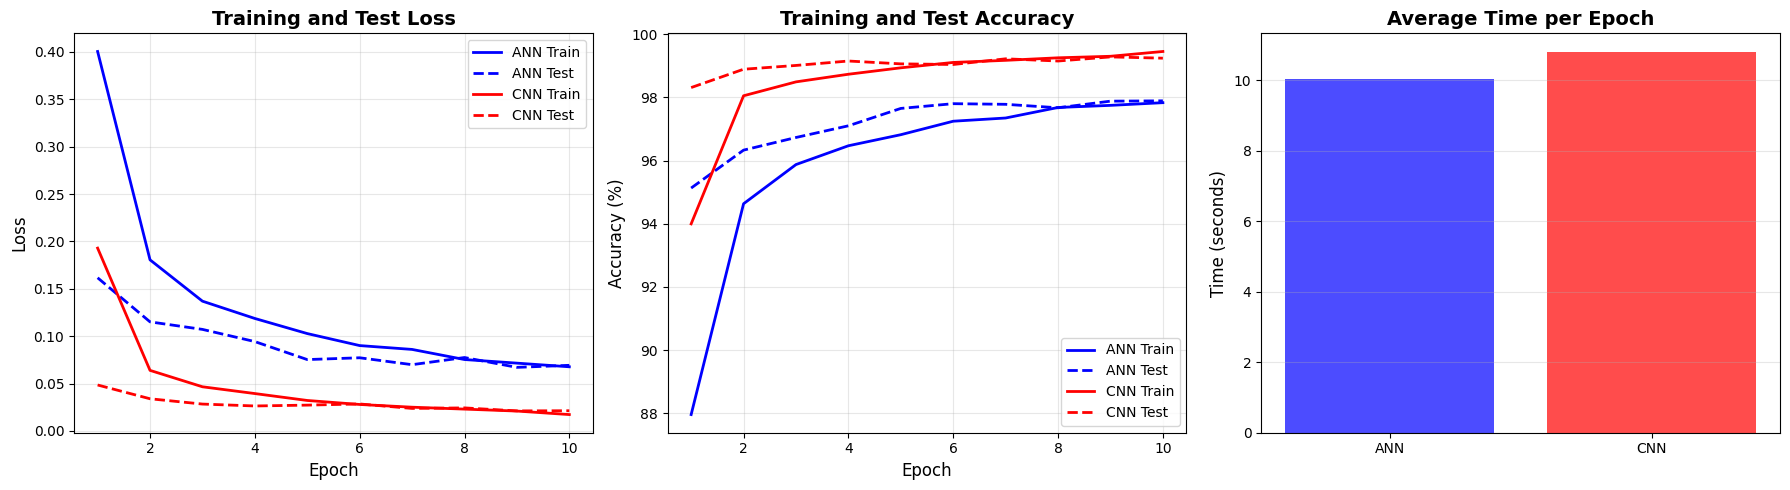


COMPARISON SUMMARY

ANN Model:
  - Final Test Accuracy: 97.89%
  - Final Test Loss: 0.0693
  - Avg. Time per Epoch: 10.04s
  - Total Parameters: 109386

CNN Model:
  - Final Test Accuracy: 99.24%
  - Final Test Loss: 0.0213
  - Avg. Time per Epoch: 10.80s
  - Total Parameters: 421642

Accuracy Improvement: 1.35%


In [9]:
# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

epochs_range = range(1, len(ann_history['train_loss']) + 1)

# Plot Training Loss
axes[0].plot(epochs_range, ann_history['train_loss'], 'b-', label='ANN Train', linewidth=2)
axes[0].plot(epochs_range, ann_history['test_loss'], 'b--', label='ANN Test', linewidth=2)
axes[0].plot(epochs_range, cnn_history['train_loss'], 'r-', label='CNN Train', linewidth=2)
axes[0].plot(epochs_range, cnn_history['test_loss'], 'r--', label='CNN Test', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Test Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot Accuracy
axes[1].plot(epochs_range, ann_history['train_acc'], 'b-', label='ANN Train', linewidth=2)
axes[1].plot(epochs_range, ann_history['test_acc'], 'b--', label='ANN Test', linewidth=2)
axes[1].plot(epochs_range, cnn_history['train_acc'], 'r-', label='CNN Train', linewidth=2)
axes[1].plot(epochs_range, cnn_history['test_acc'], 'r--', label='CNN Test', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training and Test Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# Plot Training Time per Epoch
axes[2].bar(['ANN', 'CNN'], 
           [np.mean(ann_history['time']), np.mean(cnn_history['time'])],
           color=['blue', 'red'], alpha=0.7)
axes[2].set_ylabel('Time (seconds)', fontsize=12)
axes[2].set_title('Average Time per Epoch', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("COMPARISON SUMMARY")
print("="*80)
print(f"\nANN Model:")
print(f"  - Final Test Accuracy: {ann_history['test_acc'][-1]:.2f}%")
print(f"  - Final Test Loss: {ann_history['test_loss'][-1]:.4f}")
print(f"  - Avg. Time per Epoch: {np.mean(ann_history['time']):.2f}s")
print(f"  - Total Parameters: {sum(p.numel() for p in ann_model.parameters())}")

print(f"\nCNN Model:")
print(f"  - Final Test Accuracy: {cnn_history['test_acc'][-1]:.2f}%")
print(f"  - Final Test Loss: {cnn_history['test_loss'][-1]:.4f}")
print(f"  - Avg. Time per Epoch: {np.mean(cnn_history['time']):.2f}s")
print(f"  - Total Parameters: {sum(p.numel() for p in cnn_model.parameters())}")

print(f"\nAccuracy Improvement: {cnn_history['test_acc'][-1] - ann_history['test_acc'][-1]:.2f}%")
print("="*80)

## 10. Visualize Predictions

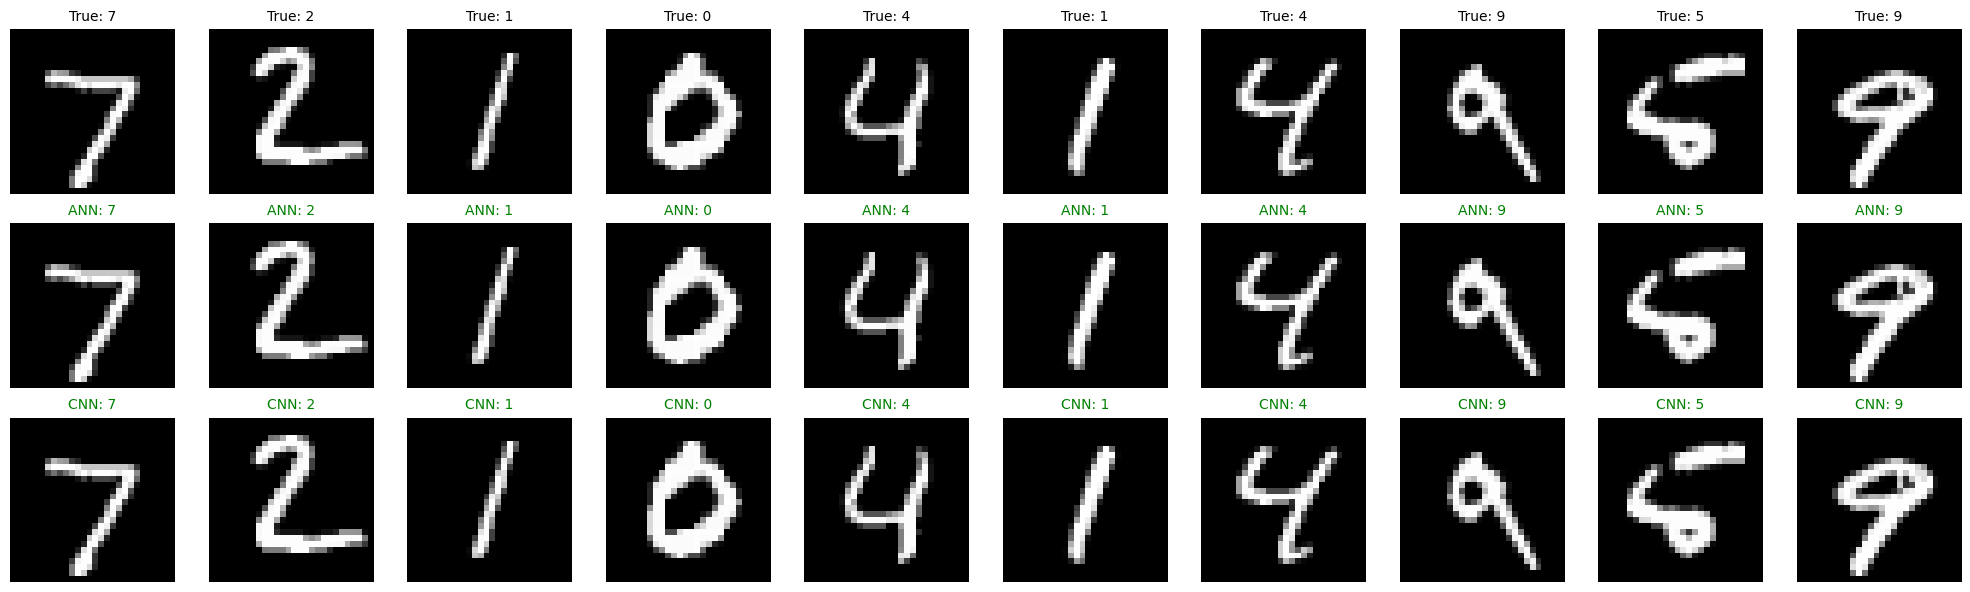

In [10]:
# Get some test samples
test_iter = iter(test_loader)
images, labels = next(test_iter)
images, labels = images.to(device), labels.to(device)

# Get predictions from both models
ann_model.eval()
cnn_model.eval()

with torch.no_grad():
    ann_outputs = ann_model(images)
    cnn_outputs = cnn_model(images)
    
    _, ann_preds = torch.max(ann_outputs, 1)
    _, cnn_preds = torch.max(cnn_outputs, 1)

# Move to CPU for visualization
images = images.cpu()
labels = labels.cpu()
ann_preds = ann_preds.cpu()
cnn_preds = cnn_preds.cpu()

# Visualize predictions
fig, axes = plt.subplots(3, 10, figsize=(20, 6))

for i in range(10):
    # Original image
    axes[0, i].imshow(images[i].squeeze(), cmap='gray')
    axes[0, i].set_title(f'True: {labels[i].item()}', fontsize=10)
    axes[0, i].axis('off')
    
    # ANN prediction
    axes[1, i].imshow(images[i].squeeze(), cmap='gray')
    color = 'green' if ann_preds[i] == labels[i] else 'red'
    axes[1, i].set_title(f'ANN: {ann_preds[i].item()}', fontsize=10, color=color)
    axes[1, i].axis('off')
    
    # CNN prediction
    axes[2, i].imshow(images[i].squeeze(), cmap='gray')
    color = 'green' if cnn_preds[i] == labels[i] else 'red'
    axes[2, i].set_title(f'CNN: {cnn_preds[i].item()}', fontsize=10, color=color)
    axes[2, i].axis('off')

axes[0, 0].set_ylabel('Ground Truth', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('ANN Predictions', fontsize=12, fontweight='bold')
axes[2, 0].set_ylabel('CNN Predictions', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 11. Confusion Matrix

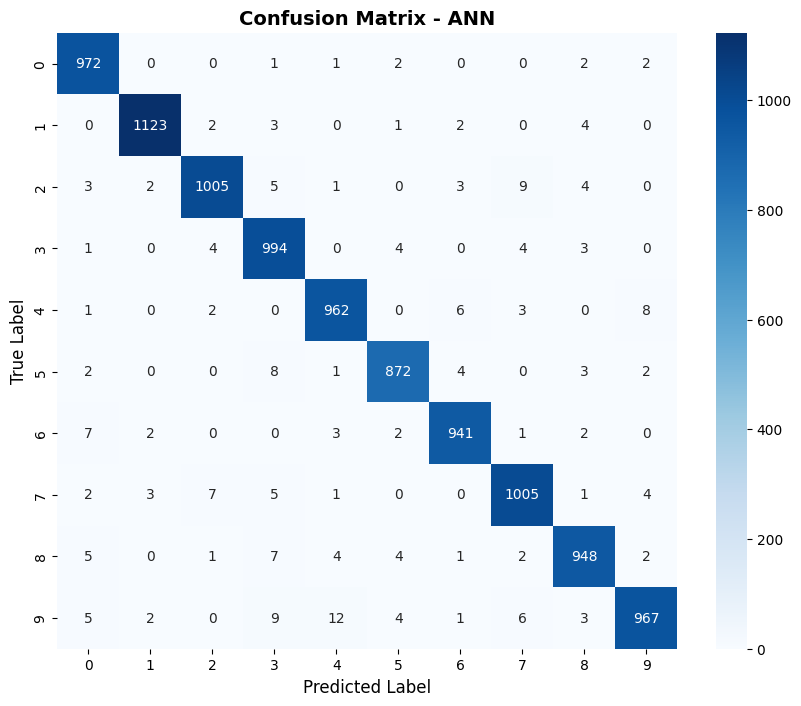


Classification Report - ANN:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.96      0.98      0.97      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.97      0.98       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



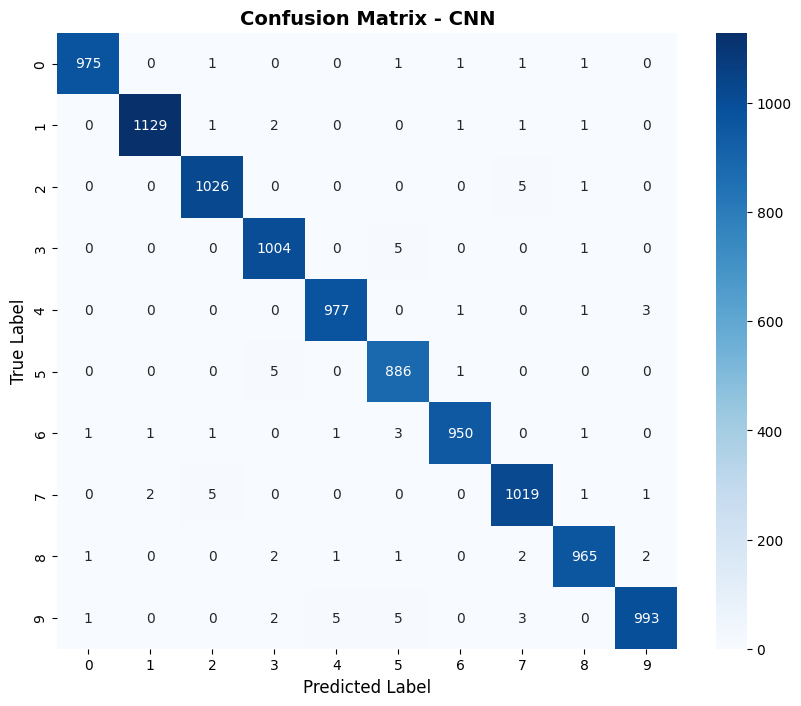


Classification Report - CNN:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       980
           1       1.00      0.99      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.98      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def plot_confusion_matrix(model, test_loader, model_name):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = output.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=range(10), yticklabels=range(10))
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.show()
    
    print(f"\nClassification Report - {model_name}:")
    print(classification_report(all_labels, all_preds, target_names=[str(i) for i in range(10)]))

# Plot confusion matrices for both models
plot_confusion_matrix(ann_model, test_loader, "ANN")
plot_confusion_matrix(cnn_model, test_loader, "CNN")

## 12. Key Observations

### ANN (Fully Connected Network)
- **Pros:**
  - Simpler architecture
  - Fewer parameters
  - Faster training per epoch
- **Cons:**
  - Loses spatial information (flattens 2D images)
  - No translation invariance
  - Lower accuracy on image tasks

### CNN (Convolutional Neural Network)
- **Pros:**
  - Preserves spatial structure
  - Translation invariant features
  - Better feature extraction for images
  - Higher accuracy
- **Cons:**
  - More complex architecture
  - More parameters (potentially)
  - Slightly slower training

### Conclusion
CNNs are significantly better suited for image classification tasks due to their ability to learn spatial hierarchies and local patterns. The convolutional and pooling layers allow the network to learn translation-invariant features, making it more robust and accurate for computer vision tasks.